In [2]:
import pandas as pd
apple_csv = pd.read_csv('Apple.csv')
amazon_csv = pd.read_csv('Amazon.csv')
google_csv = pd.read_csv('Google.csv')
micro_csv = pd.read_csv('Microsoft.csv')
netflix_csv = pd.read_csv('Netflix.csv')

apple_csv.columns = [f'Apple_{col}' if col != 'Date' else 'Date' for col in apple_csv.columns]
amazon_csv.columns = [f'Amazon_{col}' if col != 'Date' else 'Date' for col in amazon_csv.columns]
google_csv.columns = [f'Google_{col}' if col != 'Date' else 'Date' for col in google_csv.columns]
micro_csv.columns = [f'Microsoft_{col}' if col != 'Date' else 'Date' for col in micro_csv.columns]
netflix_csv.columns = [f'Netflix_{col}' if col != 'Date' else 'Date' for col in netflix_csv.columns]

merged_df = apple_csv
merged_df = pd.merge(merged_df, amazon_csv, on='Date', how='outer')
merged_df = pd.merge(merged_df, google_csv, on='Date', how='outer')
merged_df = pd.merge(merged_df, micro_csv, on='Date', how='outer')
merged_df = pd.merge(merged_df, netflix_csv, on='Date', how='outer')

# converts to proper 
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
columns_without_date = merged_df.drop(columns=['Date']).columns.tolist()
merged_df[columns_without_date] = merged_df[columns_without_date].apply(pd.to_numeric, errors='coerce')

# remove rows with missing vals
merged_df.dropna(inplace=True)

# makes date as key
merged_df.set_index('Date', inplace=True)

# removes and duplicate rows
merged_df.drop_duplicates(inplace=True)

# extracts only the years we want
df = merged_df[500:2150]
df = df.reset_index()
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Apple_Open,Apple_High,Apple_Low,Apple_Close,Apple_Adj Close,Apple_Volume,Amazon_Open,Amazon_High,Amazon_Low,...,Microsoft_Low,Microsoft_Close,Microsoft_Adj Close,Microsoft_Volume,Netflix_Open,Netflix_High,Netflix_Low,Netflix_Close,Netflix_Adj Close,Netflix_Volume
0,2006-08-14,2.287500,2.329286,2.271429,2.283571,1.943590,717620400,1.3110,1.3530,1.3090,...,24.350000,24.530001,17.597080,47831900,2.842857,2.858571,2.834286,2.844286,2.844286,5253500.0
1,2006-08-15,2.333571,2.375000,2.314286,2.373214,2.019886,861352800,1.3485,1.3930,1.3310,...,24.440001,24.620001,17.726677,48994500,2.862857,2.900000,2.830000,2.850000,2.850000,6462400.0
2,2006-08-16,2.396429,2.431071,2.368929,2.427857,2.066394,781284000,1.3985,1.4070,1.3760,...,24.469999,24.700001,17.784285,52373600,2.860000,2.877143,2.795714,2.824286,2.824286,10453800.0
3,2006-08-17,2.428571,2.452143,2.399286,2.413929,2.054539,581148400,1.3980,1.4875,1.3915,...,24.610001,24.700001,17.784285,45674800,2.800000,2.951429,2.798571,2.861429,2.861429,9569700.0
4,2006-08-18,2.418214,2.442857,2.402143,2.425357,2.064267,536354000,1.4545,1.4615,1.4110,...,24.980000,25.790001,18.569094,128414800,2.871429,2.890000,2.824286,2.835714,2.835714,5793900.0


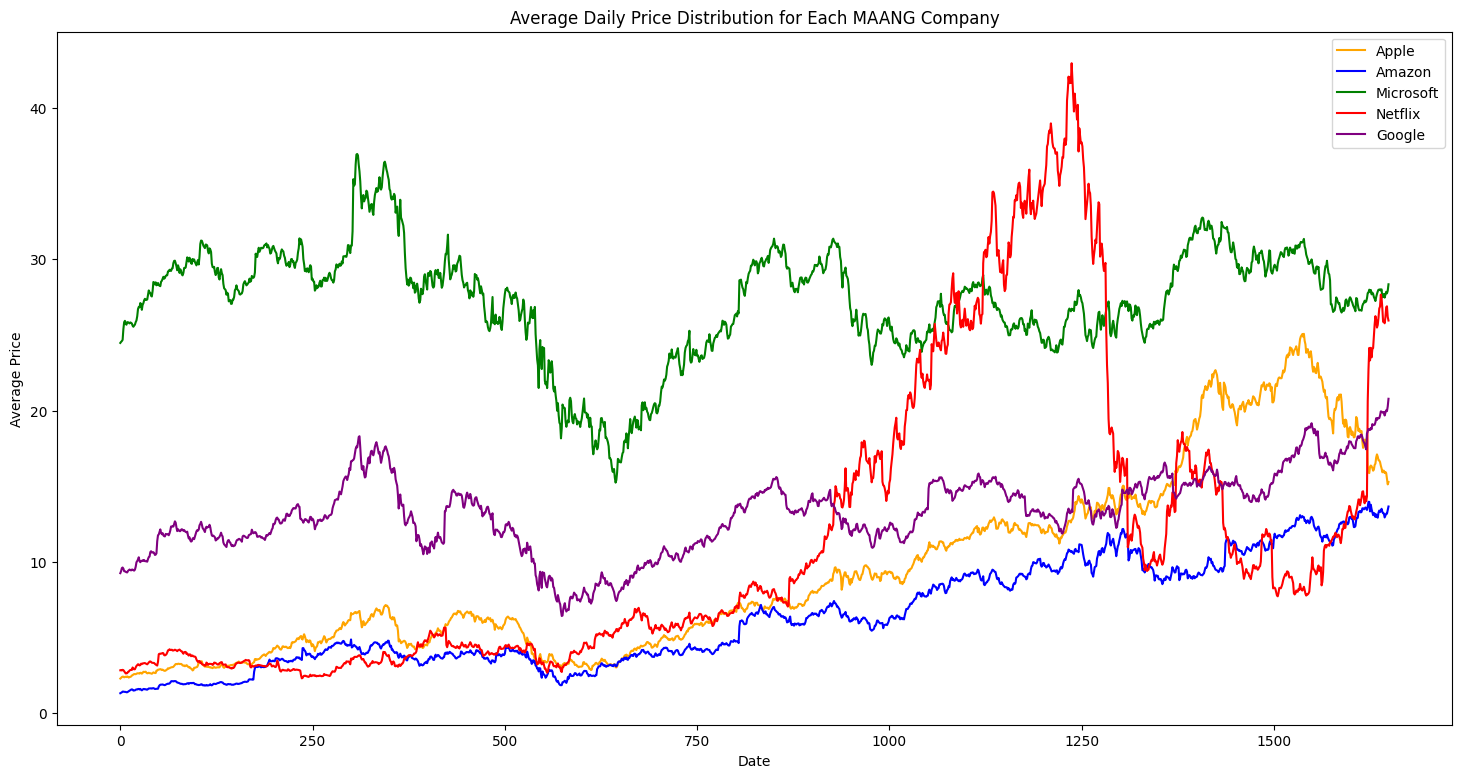

In [3]:
# Line Plot
import matplotlib.pyplot as plt

# dict of companies to line colors
companies = {
    'Apple': 'orange',
    'Amazon': 'blue',
    'Microsoft': 'green',
    'Netflix': 'red',
    'Google': 'purple'
}

# iterates and extracts the company averages per day
for company in companies.keys():
    df[f'{company}_Avg'] = (df[f'{company}_High'] + df[f'{company}_Low']) / 2

# plots the indv company average distributions
plt.figure(figsize=(18, 9))
for company, color in companies.items():
    plt.plot(df.index, df[f'{company}_Avg'], label=company, color=color)

# label and title
plt.title('Average Daily Price Distribution for Each MAANG Company')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.legend()
plt.show()

In [4]:
# Creating the line plot in D3 instead
df.to_csv('maang_data.csv', index=True)

In [5]:
# Area Graph for Total Monthly Volume
import altair as alt

volume_cols = ['Apple_Volume', 'Amazon_Volume', 'Google_Volume', 'Microsoft_Volume', 'Netflix_Volume']

# New dataframe with only monthly total volume for each company per year
# REFERENCE https://pandas.pydata.org/docs/reference/api/pandas.Grouper.html
df_monthly = df.groupby(pd.Grouper(key='Date', freq='ME')).sum()[volume_cols].reset_index()

# Selection element
selection = alt.selection_point(fields = ['Company'])

color = alt.condition(
    selection,
    alt.Color('Company:N', scale=alt.Scale(domain=volume_cols, range=list(companies.values()))).legend(None),
    alt.value(None)
)

# Area Graph
area = alt.Chart(df_monthly).transform_fold(
    volume_cols, 
    as_=['Company', 'Volume']
).mark_area(opacity=0.6).encode(
    alt.X('yearmonth(Date):T', title='Year & Month', axis=alt.Axis(format='%Y-%b')),
    alt.Y('Volume:Q', title='Total Volume of Shares', stack=None),
    color = color
).properties(
    title='Total Monthly Volume of Shares Per MAANG Company',
    width=800,
    height=400
).add_params(
    selection  
)

# Interactive Legend
legend = alt.Chart(df_monthly).transform_fold(
    volume_cols, 
    as_=['Company', 'Volume']
).mark_rect().encode(
    alt.Y('Company:N', axis=alt.Axis(orient='right')),  # Correctly reference the Company field
    color=color  # Apply the color condition to the legend as well
).add_params(
    selection
)

area_graph = area | legend

area_graph.save("area_graph_altair.html")

In [6]:
# Data pre-processing for google search trends data
trends = pd.read_csv('trends.csv')

# Filtering for the US between 2006 and 2013
trends = trends[(trends['location'] == 'United States') & (trends['year'].isin(range(2006, 2014)))]
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)
# checking what categories exist
# print(trends['category'].unique())
# Scandals, Lawsuits, Presidential Campaign, It's the Economy, Google.com Fastest Falling, Google Maps Searches, Google News Searches, Google.com Fastest Rising, Donate To, News Searches, Product Searches, Searches, Economy, Gadgets, Political Scandals, Politics, Technology, Election Issues, Stocks, Tech Gadgets, US Politicians, Events, New York City, NY

In [7]:
# Top three searches per desired category per year
desired_categories = ["Scandals", "Lawsuits", "Presidential Campaign", "It's the Economy", "Google.com Fastest Falling", 
                      "Google Maps Searches", "Google News Searches", "Google.com Fastest Rising", "Donate To", "News Searches", 
                      "Product Searches", "Searches", "Economy", "Gadgets", "Political Scandals", "Politics", "Technology", 
                      "Election Issues", "Stocks", "Tech Gadgets", "US Politicians", "Events", "New York City, NY"]

trends_top = trends[trends['rank'].isin(range(1,4))]
trends_top = trends_top[trends_top['category'].isin(desired_categories)]
trends_top

,location,year,category,rank,query
545,United States,2006,Scandals,1,Duke Lacrosse Scandal
546,United States,2006,Scandals,2,Project Runway Scandal
547,United States,2006,Scandals,3,Duke Scandal
580,United States,2007,Lawsuits,1,Borat Lawsuit
581,United States,2007,Lawsuits,2,Vonage Lawsuit
582,United States,2007,Lawsuits,3,iPhone Lawsuit
590,United States,2007,Presidential Campaign,1,Ron Paul
591,United States,2007,Presidential Campaign,2,Fred Thompson
592,United States,2007,Presidential Campaign,3,Hilary Clinton
1505,United States,2008,It's the Economy,1,Financial Crisis


In [8]:
trends_top['Year'] = trends_top['year']
# Aggregate trends data by year and category to get a count of search entries
trends_summary = trends_top.groupby(['Year', 'category']).size().reset_index(name='search_count')

# Optionally, aggregate by rank to create a weighted score (lower rank = higher impact)
trends_summary['weighted_score'] = trends_top.groupby(['Year', 'category'])['rank'].mean().values
trends_summary

,Year,category,search_count,weighted_score
0,2006,Scandals,3,2.0
1,2007,Lawsuits,3,2.0
2,2007,Presidential Campaign,3,2.0
3,2008,It's the Economy,3,2.0
4,2009,Google.com Fastest Falling,3,2.0
5,2009,Google.com Fastest Rising,3,2.0
6,2009,News Searches,3,2.0
7,2011,Donate To,3,2.0
8,2011,Economy,3,2.0
9,2011,Gadgets,3,2.0


In [9]:
price_cols = ['Apple_High', 'Apple_Low', 'Apple_Close', 
              'Amazon_High', 'Amazon_Low', 'Amazon_Close',
              'Google_High', 'Google_Low', 'Google_Close',
              'Microsoft_High', 'Microsoft_Low', 'Microsoft_Close',
              'Netflix_High', 'Netflix_Low', 'Netflix_Close']

# Dataframe of yearly total volume and average prices
df_yearly_volume = df.groupby(pd.Grouper(key='Date', freq='YE')).sum()[volume_cols].reset_index()
df_yearly_prices = df.groupby(pd.Grouper(key='Date', freq='YE')).mean()[price_cols].reset_index()
df_yearly = pd.merge(df_yearly_volume, df_yearly_prices, on='Date')

# Extract the year from the Date column
df_yearly['Year'] = df_yearly['Date'].dt.year
df_yearly.drop(columns=['Date'], inplace=True)

google_yearly = df_yearly[['Google_Volume', 'Google_High', 'Google_Low', 'Year']]
google_yearly = pd.merge(trends_top, google_yearly, left_on = 'year', right_on = 'Year')
google_yearly.rename(columns = {'query': 'Top_Query'}, inplace = True)

grouped_google = google_yearly.groupby('category').agg('min').reset_index()
grouped_google

,category,location,year,rank,Top_Query,Year_x,Google_Volume,Google_High,Google_Low,Year_y
0,Donate To,United States,2011,1,Donate to Japan,2011,3.114476e+10,14.305521,14.037592,2011
1,Economy,United States,2011,1,Debt Ceiling,2011,3.114476e+10,14.305521,14.037592,2011
2,Election Issues,United States,2012,1,Abortion,2012,2.614137e+10,16.146392,15.864414,2012
3,Events,United States,2013,1,Boston Marathon,2013,4.325782e+09,19.137773,18.850848,2013
4,Gadgets,United States,2011,1,Kindle Fire,2011,3.114476e+10,14.305521,14.037592,2011
5,Google Maps Searches,United States,2011,1,IKEA,2011,3.114476e+10,14.305521,14.037592,2011
6,Google News Searches,United States,2011,1,Hurricane Irene,2011,3.114476e+10,14.305521,14.037592,2011
7,Google.com Fastest Falling,United States,2009,1,Heath Ledger,2009,3.550490e+10,11.058242,10.821192,2009
8,Google.com Fastest Rising,United States,2009,1,Facebook,2009,3.550490e+10,11.058242,10.821192,2009
9,It's the Economy,United States,2008,1,Bailout,2008,6.421449e+10,11.814250,11.374182,2008


In [19]:
from textblob import Word
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
import pandas as pd

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Define stopwords and stock market-related words
stop_words = set(stopwords.words('english'))

# List of stock market-related words (expand this as necessary)
stock_market_terms = [
    "stock", "stocks", "economy", "shares", "equity", "bond", "trading", "market", "investment", "portfolio",
    "capital", "Google.com", "exchange", "NASDAQ", "NYSE", "bull", "bear", "IPO", "valuation",
    "commodities", "mutual fund", "asset", "google", "finance", "hedge", "yield", "futures", "rise", "fall"
]

similarity_query = []

for idx, row in grouped_google.iterrows():
    phrase = row['category'].split()

    # Remove stopwords
    filtered_phrase = [word for word in phrase if word.lower() not in stop_words]
    
    word_sum = 0
    for info in filtered_phrase:
        max_similarity = 0  # To track the highest similarity with stock market terms
        
        for stock_term in stock_market_terms:
            try:
                # Get the synsets of both the query word and the stock market term
                word1 = Word(stock_term.lower()).synsets[0]  
                word2 = Word(info.lower()).synsets[0]   
                
                # Calculate the path similarity between the query word and stock market term
                similarity = word1.path_similarity(word2)
                if similarity and similarity > max_similarity:
                    max_similarity = similarity
            except IndexError:
                print(f"One of the words ('{stock_term}' or '{info}') has no synsets, skipping similarity calculation.")
        
        # Add the highest similarity score found for this word in the query
        word_sum += max_similarity
    
    # Calculate average similarity for the whole phrase
    if len(filtered_phrase) > 0:
        similarity_query.append(word_sum / len(filtered_phrase))
    else:
        similarity_query.append(0)

# Add the similarity score to the DataFrame
grouped_google['similarity'] = similarity_query
grouped_google



One of the words ('Google.com' or 'Donate') has no synsets, skipping similarity calculation.
One of the words ('mutual fund' or 'Donate') has no synsets, skipping similarity calculation.
One of the words ('Google.com' or 'Economy') has no synsets, skipping similarity calculation.
One of the words ('mutual fund' or 'Economy') has no synsets, skipping similarity calculation.
One of the words ('Google.com' or 'Election') has no synsets, skipping similarity calculation.
One of the words ('mutual fund' or 'Election') has no synsets, skipping similarity calculation.
One of the words ('Google.com' or 'Issues') has no synsets, skipping similarity calculation.
One of the words ('mutual fund' or 'Issues') has no synsets, skipping similarity calculation.
One of the words ('Google.com' or 'Events') has no synsets, skipping similarity calculation.
One of the words ('mutual fund' or 'Events') has no synsets, skipping similarity calculation.
One of the words ('Google.com' or 'Gadgets') has no synsets

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mayaprasad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mayaprasad/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mayaprasad/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,category,location,year,rank,Top_Query,Year_x,Google_Volume,Google_High,Google_Low,Year_y,similarity to stock market,similarity
0,Donate To,United States,2011,1,Donate to Japan,2011,3.114476e+10,14.305521,14.037592,2011,0.125000,0.125000
1,Economy,United States,2011,1,Debt Ceiling,2011,3.114476e+10,14.305521,14.037592,2011,1.000000,1.000000
2,Election Issues,United States,2012,1,Abortion,2012,2.614137e+10,16.146392,15.864414,2012,0.145833,0.145833
3,Events,United States,2013,1,Boston Marathon,2013,4.325782e+09,19.137773,18.850848,2013,0.250000,0.250000
4,Gadgets,United States,2011,1,Kindle Fire,2011,3.114476e+10,14.305521,14.037592,2011,0.200000,0.200000
5,Google Maps Searches,United States,2011,1,IKEA,2011,3.114476e+10,14.305521,14.037592,2011,0.511111,0.511111
6,Google News Searches,United States,2011,1,Hurricane Irene,2011,3.114476e+10,14.305521,14.037592,2011,0.486111,0.486111
7,Google.com Fastest Falling,United States,2009,1,Heath Ledger,2009,3.550490e+10,11.058242,10.821192,2009,0.089286,0.089286
8,Google.com Fastest Rising,United States,2009,1,Facebook,2009,3.550490e+10,11.058242,10.821192,2009,0.095238,0.095238
9,It's the Economy,United States,2008,1,Bailout,2008,6.421449e+10,11.814250,11.374182,2008,1.000000,1.000000


In [22]:
import altair as alt
import pandas as pd

# Sample data (replace with your actual DataFrame)
# Make sure 'grouped_google' contains the necessary columns: 'category', 'similarity', 'year'

color_palette = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a', '#66a61e', '#a6cee3', '#8B8000']
years_extracted = grouped_google['year'].unique().tolist()

# Altair chart with values on the bars
chart = alt.Chart(grouped_google).mark_bar().encode(
    alt.X('category:N', title='Category'),
    alt.Y('similarity:Q', title='Similarity'),
    alt.Color('year:N', scale=alt.Scale(domain=years_extracted, range=color_palette)),
    alt.Text('similarity:Q', format='.2f')
).properties(
    title="Annual Trends in Search Query Categories and Their Similarity to Market Terms"
).configure_view(
    stroke=None 
).configure_axis(
    grid=False 
).configure_mark(
    opacity=1  
)

chart

alt.Chart(...)

In [12]:
stock_data = pd.read_csv('Stock Headlines.csv', encoding='ISO-8859-1')
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data = stock_data[['Date', 'Top1', 'Top2', 'Top3']]
data_with_top =pd.merge(df, stock_data, on='Date', how='inner')

In [13]:
import seaborn as sns
from textblob import TextBlob

def sentiment_score(text):
    return TextBlob(text).sentiment.polarity


for i in range(1, 4):  
    data_with_top[f'Top{i}_Sentiment'] = data_with_top[f'Top{i}'].apply(sentiment_score)

data_with_top['Average_Sentiment'] = data_with_top[[f'Top{i}_Sentiment' for i in range(1, 4)]].mean(axis=1)


daily_avg_sentiment = data_with_top.groupby('Date')['Average_Sentiment'].transform('mean')


In [14]:
import altair as alt
alt.data_transformers.enable("vegafusion")
data_with_top['Apple_Percentage_Change'] = ((data_with_top['Apple_Close'] - data_with_top['Apple_Open']) / data_with_top['Apple_Open']) * 100
data_with_top['Amazon_Percentage_Change'] = ((data_with_top['Amazon_Close'] -data_with_top['Amazon_Open']) / data_with_top['Amazon_Open']) * 100
data_with_top['Microsoft_Percentage_Change'] = ((data_with_top['Microsoft_Close'] - data_with_top['Microsoft_Open']) / data_with_top['Microsoft_Open']) * 100
data_with_top['Netflix_Percentage_Change'] = ((data_with_top['Netflix_Close'] - data_with_top['Netflix_Open']) / data_with_top['Netflix_Open']) * 100
data_with_top['Google_Percentage_Change'] = ((data_with_top['Google_Close'] - data_with_top['Google_Open']) / data_with_top['Google_Open']) * 100

melted_df = data_with_top.melt(id_vars=['Average_Sentiment'], 
                     value_vars=['Apple_Percentage_Change', 'Amazon_Percentage_Change',
                                 'Microsoft_Percentage_Change', 'Netflix_Percentage_Change',
                                 'Google_Percentage_Change'],
                     var_name='Company', value_name='Percentage_Change')
melted_df = melted_df[melted_df['Average_Sentiment'] != 0.0]


In [15]:
color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
companies = melted_df['Company'].unique().tolist()

selection_zoom = alt.selection_interval() 
selection = alt.selection_single(fields=['Company'], bind='legend')

chart = alt.Chart(melted_df).mark_circle().encode(
    y='Average_Sentiment:Q',
    x='Percentage_Change:Q',
    color=alt.Color('Company:N', scale=alt.Scale(domain=companies, range=color_palette)),
    tooltip=['Company:N', 'Average_Sentiment:Q', 'Percentage_Change:Q']
).properties(
    title='Percentage Change vs Average Sentiment by Company'
).add_params(
    selection, 
    selection_zoom  
)

zoom = alt.Chart(melted_df).mark_circle().encode(
    y='Average_Sentiment:Q',
    x='Percentage_Change:Q',
    color=alt.Color('Company:N', scale=alt.Scale(domain=companies, range=color_palette)),
).transform_filter(
    selection & selection_zoom  
).properties(
    title='Filtered Graph Based on Selection of Company and Zoom'
)
finalized_chart = chart & zoom
finalized_chart.save("sentiment_graph_altair.html")

/var/folders/_1/4ff39r7j7cs78zsqt7mb3tr80000gn/T/ipykernel_17104/2780475556.py:5: AltairDeprecationWarning: Deprecated in `altair=5.0.0`. Use selection_point instead.
  selection = alt.selection_single(fields=['Company'], bind='legend')


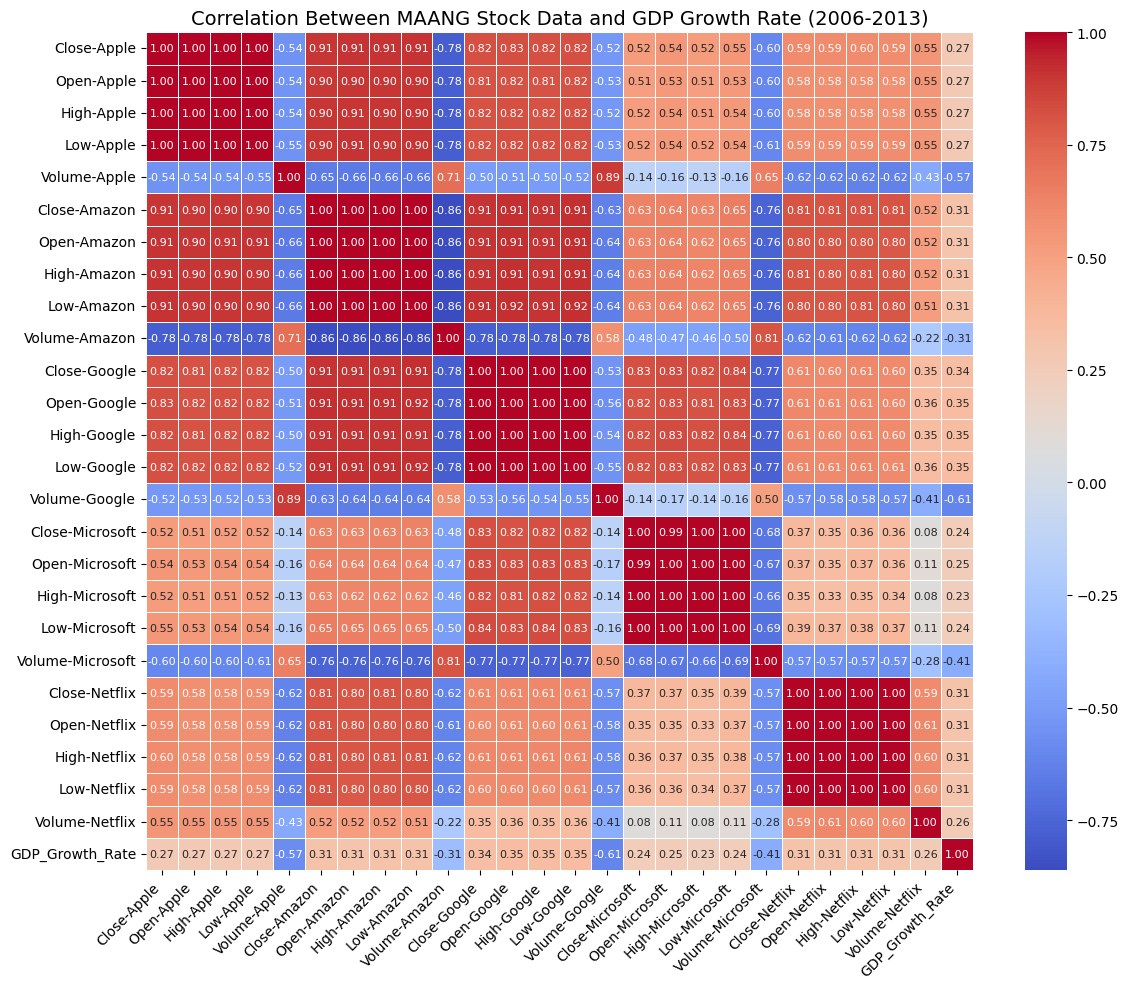

In [16]:
#Heatmap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

apple_data = pd.read_csv('Apple.csv')
amazon_data = pd.read_csv('Amazon.csv')
google_data = pd.read_csv('Google.csv')
microsoft_data = pd.read_csv('Microsoft.csv')
netflix_data = pd.read_csv('Netflix.csv')

gdp_data = pd.read_csv('GDPC1.csv')
gdp_data['DATE'] = pd.to_datetime(gdp_data['DATE'])
gdp_data['GDP_Growth_Rate'] = gdp_data['GDPC1'].pct_change() * 100
gdp_data = gdp_data[(gdp_data['DATE'] >= '2006-01-01') & (gdp_data['DATE'] <= '2013-12-31')]

def preprocess_data(data, company_name):
    data['Date'] = pd.to_datetime(data['Date'])
    data = data[(data['Date'] >= '2006-01-01') & (data['Date'] <= '2013-12-31')]
    data = data[['Date', 'Close', 'Open', 'High', 'Low', 'Volume']]
    data.columns = [f'{col}-{company_name}' if col != 'Date' else 'Date' for col in data.columns]
    return data

apple_data = preprocess_data(apple_data, 'Apple')
amazon_data = preprocess_data(amazon_data, 'Amazon')
google_data = preprocess_data(google_data, 'Google')
microsoft_data = preprocess_data(microsoft_data, 'Microsoft')
netflix_data = preprocess_data(netflix_data, 'Netflix')

merged_data = apple_data.merge(amazon_data, on='Date', how='inner') \
                        .merge(google_data, on='Date', how='inner') \
                        .merge(microsoft_data, on='Date', how='inner') \
                        .merge(netflix_data, on='Date', how='inner') \
                        .merge(gdp_data[['DATE', 'GDP_Growth_Rate']], left_on='Date', right_on='DATE', how='inner') \
                        .drop(columns=['DATE'])

data_for_heatmap = merged_data[['Close-Apple', 'Open-Apple', 'High-Apple', 'Low-Apple', 'Volume-Apple',
                                'Close-Amazon', 'Open-Amazon', 'High-Amazon', 'Low-Amazon', 'Volume-Amazon',
                                'Close-Google', 'Open-Google', 'High-Google', 'Low-Google', 'Volume-Google',
                                'Close-Microsoft', 'Open-Microsoft', 'High-Microsoft', 'Low-Microsoft', 'Volume-Microsoft',
                                'Close-Netflix', 'Open-Netflix', 'High-Netflix', 'Low-Netflix', 'Volume-Netflix',
                                'GDP_Growth_Rate']]
correlation_matrix = data_for_heatmap.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    annot_kws={"size": 8},
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    linewidths=0.5
)

plt.title("Correlation Between MAANG Stock Data and GDP Growth Rate (2006-2013)", fontsize=14)
plt.xticks(rotation=45, fontsize=10, ha='right')
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

